In [1]:
# add capability to import from parent directory
import sys, os
sys.path.insert(1, os.path.join(os.path.abspath('.'), '..'))

import pvmismatch as pvm
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Setting PV system layout cell and module parameters
str_len = 6 # number of modules in a string
str_num = 3 # number of (parallel connected) strings in the array
v_bypass = np.float64(-0.5)  # [V] trigger voltage of bypass diode
cell_area = np.float64(246.49)  # [cm^2] cell area
Isc0_T0 = 9.68 # [A] reference short circuit current
ncols_per_substr=[2]*3 # 3 bypass diodes with 2 series connected cell-columns
nrows=10 # number of cell rows in the module

# Building PV modules and system
pv_mod_pattern = pvm.pvmodule.standard_cellpos_pat(nrows=nrows,
                                                   ncols_per_substr=ncols_per_substr)
pv_mod = pvm.pvmodule.PVmodule(cell_pos=pv_mod_pattern, pvcells=None,
                               pvconst=None, Vbypass=v_bypass, cellArea=cell_area)


In [3]:
pv_cells = pv_mod.pvcells
for c in pv_cells:
    c.update(diode_model = 'pvsyst', aRBD=0.0, bRBD=0.0, Isc0_T0 = Isc0_T0) # updating short circuit currents

pv_mod.setSuns(cells=list(range(0, len(pv_cells))), Ee=[1]*len(pv_cells))

pv_str = pvm.pvstring.PVstring(numberMods=str_len, pvmods=[pv_mod]*str_len)

pv_sys = pvm.pvsystem.PVsystem(numberStrs=str_num, pvstrs=[pv_str]*str_num,
                               numberMods=[str_len]*str_num,
                               pvmods=[pv_mod]*str_len)

<PVcell(Ee=1[suns], Tcell=298.15[K], Isc=9.68[A], Voc=0.687842[V])>
(9.684125625749223, 2.28618816125344e-11, 0.004267236774264931, 10.01226369025448, 0.025692570400413114)


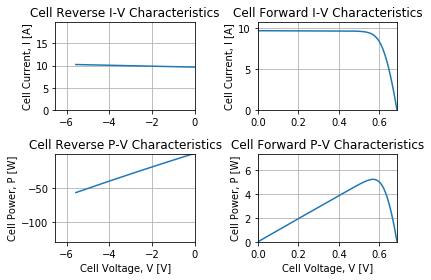

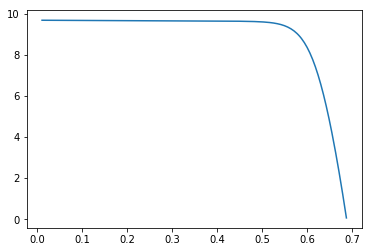

In [4]:
pv_cells[0].plot()

print(pv_mod.pvcells[0])

(photocurrent, saturation_current, resistance_series, resistance_shunt, nVth) = \
    pv_mod.pvcells[0].Aph * pv_mod.pvcells[0].Isc, pv_mod.pvcells[0].Isat1, \
    pv_mod.pvcells[0].Rs, pv_mod.pvcells[0].Rsh, \
    pv_mod.pvcells[0].N1 * pv_mod.pvcells[0].Vt

print((photocurrent, saturation_current, resistance_series, resistance_shunt, nVth))

(V_pvm, I_pvm) = pv_mod.pvcells[0].Vcell, pv_mod.pvcells[0].Icell
u = (V_pvm>=0.) & (I_pvm>=0.)
I_pvm = I_pvm[u]
V_pvm = V_pvm[u]

plt.figure()
plt.plot(V_pvm, I_pvm)
plt.show()

[1.77635684e-15 0.00000000e+00 1.77635684e-15 0.00000000e+00
 1.77635684e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.77635684e-15 0.00000000e+00
 1.77635684e-15 0.00000000e+00 1.77635684e-15 1.77635684e-15
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.77635684e-15 1.77635684e-15 1.77635684e-15 1.77635684e-15
 1.77635684e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.77635684e-15 0.00000000e+00 1.77635684e-15 1.77635684e-15
 1.77635684e-15 1.77635684e-15 0.00000000e+00 1.77635684e-15
 1.77635684e-15 1.77635684e-15 1.77635684e-15 1.77635684e-15
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.77635684e-15 1.77635684e-15 1.77635684e-15
 1.77635684e-15 1.77635684e-15 0.00000000e+00 1.77635684e-15
 1.77635684e-15 0.00000000e+00 1.77635684e-15 1.77635684e-15
 0.00000000e+00 0.00000000e+00 1.77635684e-15 1.77635684e-15
 0.00000000e+00 1.77635684e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

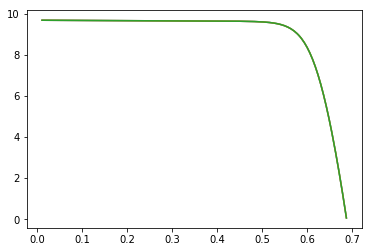

In [5]:
import pvlib

v_pvl = V_pvm
i_pvl_brentq = pvlib.pvsystem.i_from_v(resistance_shunt, resistance_series, nVth, V_pvm, saturation_current, photocurrent,
                                       method='brentq')
i_pvl_newton = pvlib.pvsystem.i_from_v(resistance_shunt, resistance_series, nVth, V_pvm, saturation_current, photocurrent,
                                       method='newton')
i_pvl_lambertw = pvlib.pvsystem.i_from_v(resistance_shunt, resistance_series, nVth, V_pvm, saturation_current, photocurrent,
                                         method='lambertw')

print(np.abs(I_pvm - i_pvl_lambertw))

plt.plot(v_pvl, i_pvl_brentq)
plt.plot(v_pvl, i_pvl_newton)
plt.plot(v_pvl, i_pvl_lambertw)

1.5987211554602254e-14


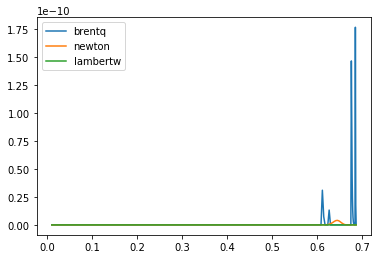

In [6]:
plt.plot(v_pvl, np.abs(i_pvl_brentq - I_pvm))
plt.plot(v_pvl, np.abs(i_pvl_newton - I_pvm))
plt.plot(v_pvl, np.abs(i_pvl_lambertw - I_pvm))
plt.legend(['brentq', 'newton', 'lambertw'])
print(np.max(np.abs(i_pvl_lambertw - I_pvm)))

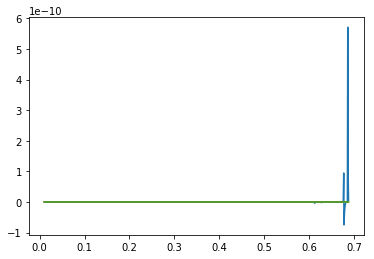

In [7]:
plt.plot(V_pvm, (I_pvm - i_pvl_brentq) / I_pvm)
plt.plot(V_pvm, (I_pvm - i_pvl_newton) / I_pvm)
plt.plot(V_pvm, (I_pvm - i_pvl_lambertw) / I_pvm)

4.49089099241462e-10
7.028155835087091e-12
2.7977620220553945e-14


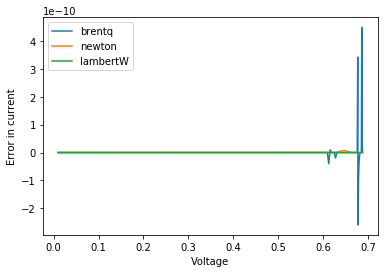

In [8]:
def sde_resid(v, i, iph, io, rs, rsh, nNsVth):
    """
    Calculate the residual for current for a single diode equation at (v, i).
    """
    return iph - io * np.expm1((v + i * rs) / nNsVth) - (v + i * rs) / rsh - i

i_resid_lambertw = sde_resid(v_pvl, i_pvl_lambertw, iph=photocurrent, io=saturation_current,
                             rs=resistance_series, rsh=resistance_shunt, nNsVth=nVth)
i_resid_brentq = sde_resid(v_pvl, i_pvl_brentq, iph=photocurrent, io=saturation_current,
                           rs=resistance_series, rsh=resistance_shunt, nNsVth=nVth)
i_resid_newton = sde_resid(v_pvl, i_pvl_newton, iph=photocurrent, io=saturation_current,
                           rs=resistance_series, rsh=resistance_shunt, nNsVth=nVth)

plt.plot(v_pvl, i_resid_brentq)
plt.plot(v_pvl, i_resid_newton)
plt.plot(v_pvl, i_resid_lambertw)
plt.legend(['brentq', 'newton', 'lambertW'])
plt.ylabel('Error in current')
plt.xlabel('Voltage')
print(np.max(np.abs(i_resid_brentq)))
print(np.max(np.abs(i_resid_newton)))
print(np.max(np.abs(i_resid_lambertw)))


[4.18332036e-13 4.18332036e-13 1.41179329e+01 2.65394398e+01
 2.94990578e+01 3.05834944e+01 3.12530092e+01 3.17322097e+01
 3.21092076e+01 3.24247031e+01 3.26963363e+01 3.29342441e+01
 3.31462463e+01 3.33383632e+01 3.35152204e+01 3.36803625e+01
 3.38364987e+01 3.39785595e+01 3.41150955e+01 3.42476392e+01
 3.43689905e+01 3.44888708e+01 3.46027584e+01 3.47126789e+01
 3.48201046e+01 3.49223410e+01 3.50240373e+01 3.51203865e+01
 3.52170039e+01 3.53088833e+01 3.54010016e+01 3.54895269e+01
 3.55776646e+01 3.56637130e+01 3.57483355e+01 3.58325946e+01
 3.59141211e+01 3.59971290e+01 3.60759388e+01 3.61566613e+01
 3.62345531e+01 3.63128457e+01 3.63906054e+01 3.64667898e+01
 3.65446380e+01 3.66190089e+01 3.66951847e+01 3.67699424e+01
 3.68445385e+01 3.69199690e+01 3.69932423e+01 3.70682938e+01
 3.71416084e+01 3.72155496e+01 3.72899139e+01 3.73629731e+01
 3.74378053e+01 3.75107997e+01 3.75849482e+01 3.76592460e+01
 3.77329181e+01 3.78083780e+01 3.78819070e+01 3.79570806e+01
 3.80320990e+01 3.810717

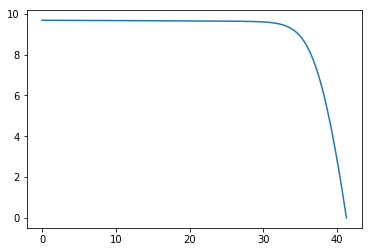

In [9]:
Vmod = pv_mod.Vmod
Imod = pv_mod.Imod
# Voc = pv_mod.Voc.sum()  # only an estimate of Voc, not precise
u = (Vmod>=0.) & (Imod>=0.)
Imod = Imod[u]
Vmod = Vmod[u]

print(Vmod)
print(Imod)
plt.plot(Vmod, Imod)

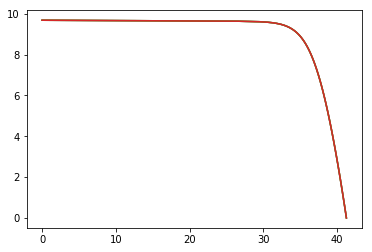

In [13]:
Ns = 60
Imod_brentq = pvlib.pvsystem.i_from_v(resistance_shunt=Ns*resistance_shunt, resistance_series=Ns*resistance_series,
                                      nNsVth=Ns*nVth, voltage=Vmod, saturation_current=saturation_current,
                                      photocurrent=photocurrent, method='brentq')
Imod_newton = pvlib.pvsystem.i_from_v(resistance_shunt=Ns*resistance_shunt, resistance_series=Ns*resistance_series,
                                      nNsVth=Ns*nVth, voltage=Vmod, saturation_current=saturation_current,
                                      photocurrent=photocurrent, method='newton')
Imod_lambertw = pvlib.pvsystem.i_from_v(resistance_shunt=Ns*resistance_shunt, resistance_series=Ns*resistance_series,
                                        nNsVth=Ns*nVth, voltage=Vmod, saturation_current=saturation_current,
                                        photocurrent=photocurrent, method='lambertw')

plt.plot(Vmod, Imod)
plt.plot(Vmod, Imod_brentq)
plt.plot(Vmod, Imod_newton)
plt.plot(Vmod, Imod_lambertw)


In [11]:
Imod_resid_brentq = sde_resid(v=Vmod, i=Imod_brentq, iph=photocurrent, io=saturation_current,
                              rs=resistance_series*Ns, rsh=resistance_shunt*Ns, nNsVth=nVth*Ns)
Imod_resid_newton = sde_resid(v=Vmod, i=Imod_newton, iph=photocurrent, io=saturation_current,
                              rs=resistance_series*Ns, rsh=resistance_shunt*Ns, nNsVth=nVth*Ns)
Imod_resid_lambertw = sde_resid(v=Vmod, i=Imod_lambertw, iph=photocurrent, io=saturation_current,
                                rs=resistance_series*Ns, rsh=resistance_shunt*Ns, nNsVth=nVth*Ns)

Text(0.5,0,'Voltage')

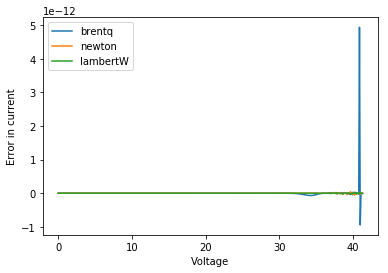

In [12]:
plt.plot(Vmod, Imod_resid_brentq)
plt.plot(Vmod, Imod_resid_newton)
plt.plot(Vmod, Imod_resid_lambertw)
plt.legend(['brentq', 'newton', 'lambertW'])
plt.ylabel('Error in current')
plt.xlabel('Voltage')

In [21]:
def _next_current(v, i, iph, io, rsh, rs, nNsVth):
    next_X = np.log((v + iph * rs + io * rs ) / nNsVth - (1 + rs / rsh) * (v + i * rs) / nNsVth) - np.log(io * rs / nNsVth)
    return (nNsVth * next_X - v) / rs

eps = 5e-17

def converge_current(v, i, iph, io, rsh, rs, nNsVth):
    i_conv = np.nan * i
    max_iter = 10
    for k in range(len(i)):
        converged = False
        iter=0
        i_last = i[k]
        while not converged and (iter < max_iter):
            iter += 1
            i_next = _next_current(v[k], i_last, iph, io, rsh, rs, nNsVth)
            print(i_last, i_next)
            converged = np.abs(i_next - i_last) < eps
            i_last = i_next
        if converged:
            i_conv[k] = i_next
    return i_conv

i_conv = converge_current(Vmod, Imod_lambertw, iph=photocurrent, io=saturation_current,
                          rsh=resistance_shunt*Ns, rs=resistance_series*Ns, nNsVth=nVth*Ns)
print(i_conv)

9.679999999999998 9.68003793890756
9.68003793890756 nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
9.679999999999998 9.68003793890756
9.68003793890756 nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
9.656507866288223 9.656507875857933
9.656507875857933 9.602847417869235
9.602847417869235 74.77147425185561
74.77147425185561 nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
9.632447839563271 9.632447839572427
9.632447839572427 9.632447823332367
9.632447823332367 9.632476643356446
9.632476643356446 9.581113569662918
9.581113569662918 26.374824817370367
26.374824817370367 nan
nan nan
nan nan
nan nan
nan nan
9.607870921138685 9.607870921142158
9.607870921142158 9.607870920237211
9.607870920237211 9.607871156662613
9.607871156662613 9.607809386593711
9.607809386593711 9.623926338516613
9.623926338516613 2.424852480229911
2.424852480229911 44.19924200722603
44.19924200722603 nan
nan nan
nan nan
9.58273714779705 9.582737147800772
9.582737147800772 9.5

C:\Users\cwhanse\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [18]:
print(Vmod)
print(Imod)

[4.18332036e-13 4.18332036e-13 1.41179329e+01 2.65394398e+01
 2.94990578e+01 3.05834944e+01 3.12530092e+01 3.17322097e+01
 3.21092076e+01 3.24247031e+01 3.26963363e+01 3.29342441e+01
 3.31462463e+01 3.33383632e+01 3.35152204e+01 3.36803625e+01
 3.38364987e+01 3.39785595e+01 3.41150955e+01 3.42476392e+01
 3.43689905e+01 3.44888708e+01 3.46027584e+01 3.47126789e+01
 3.48201046e+01 3.49223410e+01 3.50240373e+01 3.51203865e+01
 3.52170039e+01 3.53088833e+01 3.54010016e+01 3.54895269e+01
 3.55776646e+01 3.56637130e+01 3.57483355e+01 3.58325946e+01
 3.59141211e+01 3.59971290e+01 3.60759388e+01 3.61566613e+01
 3.62345531e+01 3.63128457e+01 3.63906054e+01 3.64667898e+01
 3.65446380e+01 3.66190089e+01 3.66951847e+01 3.67699424e+01
 3.68445385e+01 3.69199690e+01 3.69932423e+01 3.70682938e+01
 3.71416084e+01 3.72155496e+01 3.72899139e+01 3.73629731e+01
 3.74378053e+01 3.75107997e+01 3.75849482e+01 3.76592460e+01
 3.77329181e+01 3.78083780e+01 3.78819070e+01 3.79570806e+01
 3.80320990e+01 3.810717